In [33]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chi2
from scipy.spatial.distance import pdist, squareform
import plotly.express as px
import time
from concurrent.futures import ThreadPoolExecutor

## Task 1

Preliminarly, verify the form of the density function $ρ(r)$ by inferring it from the particle distribution
and compare it with the analytical density function described in the original paper
by Hernquist (from 1990 on Astrophysical Journal available on the web). Use Poissonian error
bars1 when comparing the numerical density profile with the analytical expected values.

Note that the initial conditions are given in a system of units in which G=1. Assume reasonable
units of length and mass for your calculations (units of velocity and time follow automatically
from the assumption G=1) and discuss your choice.

As mentioned the data is initialized with G = 1, then one has to set some unit scales to describe the system physically. Since the questioned distribution of star resembles a globular cluster (GC) then in this case for distance we will use 1 parsec $[pc]$ and 1 solar mass $[M_{\odot}]$. Specifying these scales with CGS units one gets: 


$[pc] = 3.086 \cdot 10^{18} [cm]$ 

$[M_{\odot}] = 1.989 \cdot 10^{33} [g]$ 

From these the time scale and velocity should follow from:

$[S] = \sqrt{\frac{[R]^3}{G \cdot [M]}}$

$[time] = \sqrt{\frac{[length]^3}{G \cdot [mass]}}$

So if we assign for data the length and mass scales 1 $pc$ and 1 $M_{\odot}$ then the time and velocity will be in CGS system:

$[S] = 1.216 \cdot 10^{11} [s]$

First let's read in the data (success)

I will add a "distance" column to the data which describes each stars' distance from the center

In [2]:
# Specify the file path
file_path = './data.txt'

# Define column names
column_names = ['mass', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'soft', 'pot']

# Read the .txt file into a DataFrame
df_stars = pd.read_csv(file_path, sep='\t', header=None, names=column_names)

# Add distance
df_stars['distance'] = np.sqrt(df_stars['x']**2 + df_stars['y']**2 + df_stars['z']**2)

# Display the DataFrame
df_stars.describe()

mass             x             y             z            vx  \
count  5.001000e+04  50010.000000  50010.000000  50010.000000  50010.000000   
mean   9.242590e+01     -0.016719     -0.019048      0.020731     -2.439695   
std    6.330999e-11      4.177673      5.778122      4.815739   1788.472427   
min    9.242590e+01   -278.837000   -635.776000   -269.974000  -7231.980000   
25%    9.242590e+01     -0.078246     -0.078350     -0.078522  -1043.697500   
50%    9.242590e+01     -0.000038     -0.000246      0.000005     -3.254445   
75%    9.242590e+01      0.078801      0.076801      0.079093   1037.512500   
max    9.242590e+01    199.444000    604.998000    354.422000   7525.940000   

                 vy            vz          soft           pot      distance  
count  50010.000000  50010.000000  5.001000e+04  5.001000e+04  50010.000000  
mean      10.367863      4.887935  1.000000e-01  1.302150e-02      1.083783  
std     1797.099842   1764.619866  1.323954e-14  5.880771e-16      8.535658  
min    -7930.760000  -7952.250000  1.000000e-01  1.302150e-02      0.000366  
25%    -1036.050000  -1004.350000  1.000000e-01  1.302150e-02      0.079031  
50%        9.534195      9.986930  1.000000e-01  1.302150e-02      0.188728  
75%     1051.287500   1023.600000  1.000000e-01  1.302150e-02      0.505495  
max     7874.570000   7595.740000  1.000000e-01  1.302150e-02    724.689658

In [3]:
df_stars

mass         x         y         z         vx        vy          vz  \
0      92.4259 -0.003816 -0.079670 -0.019072  3779.6200   354.734   -73.45010   
1      92.4259 -0.032298 -0.249461 -0.010890  3250.5900  -674.280   -18.33470   
2      92.4259  0.067577 -0.810356 -0.006849  2190.8600   199.053     3.86061   
3      92.4259 -0.152755  0.276704 -0.002704 -2695.1400 -1345.020   105.94600   
4      92.4259 -0.216623  0.150557 -0.002755 -1811.8900 -2595.570    85.85910   
...        ...       ...       ...       ...        ...       ...         ...   
50005  92.4259 -0.034591 -0.004853  0.038082  2274.8300  4239.630  -225.45900   
50006  92.4259  0.100105 -0.006709 -0.025669  -751.0680 -1963.650   113.92200   
50007  92.4259  0.045565 -0.075928  0.023182  -782.9830   581.401   608.46500   
50008  92.4259  0.273587  0.567563  0.255294   -20.4115  -212.075  -715.19100   
50009  92.4259 -0.122016 -0.116939 -0.217751   360.5420   113.263  3277.85000   

       soft       pot  distance  
0       0.1  0.013022  0.082010  
1       0.1  0.013022  0.251779  
2       0.1  0.013022  0.813198  
3       0.1  0.013022  0.316080  
4       0.1  0.013022  0.263819  
...     ...       ...       ...  
50005   0.1  0.013022  0.051675  
50006   0.1  0.013022  0.103561  
50007   0.1  0.013022  0.091535  
50008   0.1  0.013022  0.679818  
50009   0.1  0.013022  0.275641  

[50010 rows x 10 columns]

First plotting the stars in a 3d coordinate system

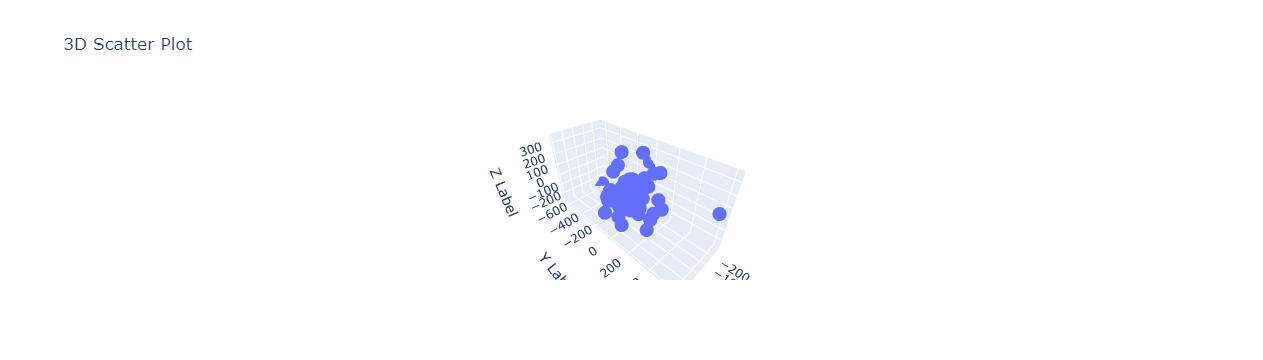

In [4]:
# Assuming df is your DataFrame
# Replace 'x', 'y', 'z' with your actual column names
fig = px.scatter_3d(df_stars, x='x', y='y', z='z', title='3D Scatter Plot', size_max = 1)

# You can customize the labels for each axis
fig.update_layout(scene=dict(xaxis_title='X Label', yaxis_title='Y Label', zaxis_title='Z Label'))

# Show the interactive plot
fig.show()

First let's define Hernquist profile for the system. We can get the total mass for the system, since the data for that is given. The r is a variable in my control also. What is unknown is the scale factor a which I will get once I fit the profile to empirical data. Fot that I will use scipy's curve_fit.

I will describe the poissonian error as follows:

$e_{pos} = \frac{\left|\rho_{exact}-\rho_{numerical} \right|}{\sqrt{N_{\rho}}}$

where $\rho_{exact}$ and $\rho_{numerical}$ are the star densities form the solved hernquist profile and numerical profile respectively. $N_{\rho}$ indicates the number of stars per bin

To get the first quess fot the hernquist profile scale radius I will use the half mass formula from the hernquist profile:

$r_{\frac{1}{2}} = (1 + \sqrt{2}) \cdot a$

Since all the stars in this system have same masses, the half mass radius is straight forward. I will find the radius where the radius is when around 25005 stars are left.

In [6]:
r_half = 0.18874
f_df_stars = df_stars[df_stars['distance'] <= r_half]
f_df_stars.describe()

mass             x             y             z            vx  \
count  2.500500e+04  25005.000000  25005.000000  25005.000000  25005.000000   
mean   9.242590e+01     -0.000367      0.000006     -0.000435      2.822476   
std    2.087616e-11      0.057361      0.056588      0.056842   2192.670435   
min    9.242590e+01     -0.185048     -0.184957     -0.185508  -7231.980000   
25%    9.242590e+01     -0.031586     -0.030978     -0.031469  -1478.490000   
50%    9.242590e+01     -0.000219      0.000088     -0.000340      1.957230   
75%    9.242590e+01      0.030804      0.031566      0.030747   1486.950000   
max    9.242590e+01      0.187356      0.185406      0.184472   7525.940000   

                 vy            vz          soft           pot      distance  
count  25005.000000  25005.000000  2.500500e+04  2.500500e+04  25005.000000  
mean       8.298934      3.762507  1.000000e-01  1.302150e-02      0.085063  
std     2212.636519   2178.371775  4.714379e-14  2.494582e-15      0.049877  
min    -7930.760000  -7952.250000  1.000000e-01  1.302150e-02      0.000366  
25%    -1496.320000  -1457.980000  1.000000e-01  1.302150e-02      0.042932  
50%        9.200410      7.494210  1.000000e-01  1.302150e-02      0.079029  
75%     1505.600000   1472.740000  1.000000e-01  1.302150e-02      0.123677  
max     7874.570000   7595.740000  1.000000e-01  1.302150e-02      0.188707

So this brute force half mass radius seems to be around 0.18874 $pc$ from this the a will be

In [7]:
a_guess = r_half / ( 1 + np.sqrt(2))
print(f'a_guess is {a_guess}')

a_guess is 0.07817866776229795


In [8]:
total_mass = df_stars.shape[0]*df_stars["mass"].values[0]#N stars times mass, since they all the sam I fix it in the profile
print(f'Total mass of the system is {total_mass} M_sol')

Total mass of the system is 4622219.259 M_sol


The hernquist profile is defined as follows


$\rho(r) = \frac{M_{tot}}{2 \cdot \pi} \frac{a}{r} \frac{1}{(r+a)^3} \quad[\frac{M_{\odot}}{{pc}^3}]$

Since the total mass is fixed the only unknown will be the scale radius a

In [9]:
#Defininf total mass and hernquist profiles
total_mass = df_stars.shape[0]*df_stars["mass"].values[0]#N stars times mass, since they all the sam I fix it in the profile

def hernquist_profile(r, M, a):
    return M / (2 * np.pi) * (a / r) * (1/(r + a)**3)

def hernquist_profile_fixed_M(r, a):
    return total_mass / (2 * np.pi) * (a / r) * (1/(r + a)**3)

PLot the observed data density and its radial dependence

/scratch/tmp.43070038.atepper/ipykernel_119494/3333241215.py:23: RuntimeWarning:

divide by zero encountered in divide



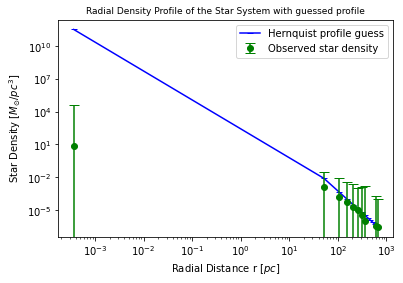

In [10]:
# define radial distances
radial_distances = df_stars["distance"]

# Define radial bins with equal length
bins = np.linspace(np.min(radial_distances), np.max(radial_distances), 15)

#bins = np.logspace(np.log(np.min(radial_distances)), np.log(np.max(radial_distances)), 50)
# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=bins)

#find the denisty of stars in solar_masses per cubic parsec
# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
lone_star_mass = df_stars["mass"].values[0]
star_density = hist*lone_star_mass / shell_volumes 

#Guessef fixed mass profile
fixed_M_fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], a_guess)

#Error
e_pos = abs(fixed_M_fitted_profile-star_density)/np.sqrt(hist)#Encounter zero


# Plot the radial density profile with logarithmic bins
plt.plot(bin_edges[:-1], fixed_M_fitted_profile, marker='_',label='Hernquist profile guess', color='blue')
#plt.scatter(bin_edges[1:], star_density, marker='o',label='Observed star density', color='green')
plt.errorbar(bin_edges[:-1],star_density, yerr=np.sqrt(e_pos), fmt='o', capsize=5,label='Observed star density', color='green')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Radial Distance r $[pc]$')
plt.ylabel('Star Density [$M_{\odot}/{pc}^3$]')
plt.title('Radial Density Profile of the Star System with guessed profile', fontsize = 9)
plt.show()

Using the a guess falls in to the error bars for the outer stars, but the profile has problems near center. Maybe because of binning.

Now try to fit the profile

In [11]:
total_mass = df_stars.shape[0]*df_stars["mass"].values[0]#N stars times mass, since they all the sam I fix it in the profile
def hernquist_profile_fixed_M(r, a):
    return total_mass / (2 * np.pi) * (a / r) * (1/(r + a)**3)

/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/lib64/python3.10/site-packages/scipy/optimize/_minpack_py.py:756: RuntimeWarning:

divide by zero encountered in divide

/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/lib64/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated

/scratch/tmp.43070038.atepper/ipykernel_119494/428110446.py:24: RuntimeWarning:

divide by zero encountered in divide



fixed mass profile a value:[0.07817867]


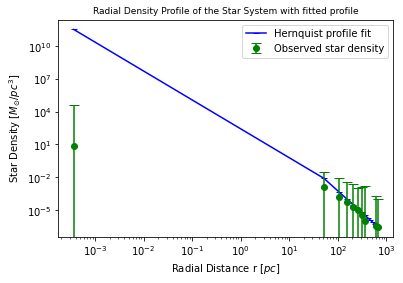

In [12]:
# define radial distances
radial_distances = df_stars["distance"]

# Define radial bins with equal length
bins = np.linspace(np.min(radial_distances), np.max(radial_distances), 15)

# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=bins)

# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
lone_star_mass = df_stars["mass"].values[0]
star_density = hist*lone_star_mass / shell_volumes 


a_fit, pcov = curve_fit(hernquist_profile_fixed_M, bin_edges[:-1], star_density, p0=a_guess, sigma = np.sqrt(star_density),absolute_sigma = True)
fixed_M_fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], a_fit)
print(f'fixed mass profile a value:{a_fit}')


#Error
e_pos = abs(fixed_M_fitted_profile-star_density)/np.sqrt(hist)#Encounter zero




# Plot the radial density profile with logarithmic bins
plt.plot(bin_edges[:-1], fixed_M_fitted_profile, marker='_',label='Hernquist profile fit', color='blue')
#plt.scatter(bin_edges[1:], star_density, marker='o',label='Observed star density', color='green')
plt.errorbar(bin_edges[:-1],star_density, yerr=np.sqrt(e_pos), fmt='o', capsize=5,label='Observed star density', color='green')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Radial Distance r $[pc]$')
plt.ylabel('Star Density [$M_{\odot}/{pc}^3$]')
plt.title('Radial Density Profile of the Star System with fitted profile', fontsize = 9)
plt.show()

Comparing a fit and a guess:

In [13]:
a_guess

0.07817866776229795

In [14]:
a_fit

array([0.07817867])

In [15]:
pcov

array([[inf]])

Still have to do something about the binning the pcov is inf

In [16]:
a_fit

array([0.07817867])

a_fit

Compute the direct N-Body forces between particles (note that the array potential[i] is not
needed for this purpose). Start by assuming a softening of the order of the mean interparticle
separation in the system, then repeat the force calculation by experimenting with different
values of the softening and discuss your results.

The mean interparticle separation in the system should be calculated inside the half-mass radius 

$r_{\frac{1}{2}} = (1 + \sqrt{2}) \cdot a$

In [17]:
r_half = (1 + np.sqrt(2))*a_fit
print(f'fitted half mass radius: {r_half} [pc]')

fitted half mass radius: [0.18874] [pc]


In [18]:
f_df_stars = df_stars[df_stars['distance'] <= r_half[0]]
f_df_stars.describe()

mass             x             y             z            vx  \
count  2.500500e+04  25005.000000  25005.000000  25005.000000  25005.000000   
mean   9.242590e+01     -0.000367      0.000006     -0.000435      2.822476   
std    2.087616e-11      0.057361      0.056588      0.056842   2192.670435   
min    9.242590e+01     -0.185048     -0.184957     -0.185508  -7231.980000   
25%    9.242590e+01     -0.031586     -0.030978     -0.031469  -1478.490000   
50%    9.242590e+01     -0.000219      0.000088     -0.000340      1.957230   
75%    9.242590e+01      0.030804      0.031566      0.030747   1486.950000   
max    9.242590e+01      0.187356      0.185406      0.184472   7525.940000   

                 vy            vz          soft           pot      distance  
count  25005.000000  25005.000000  2.500500e+04  2.500500e+04  25005.000000  
mean       8.298934      3.762507  1.000000e-01  1.302150e-02      0.085063  
std     2212.636519   2178.371775  4.714379e-14  2.494582e-15      0.049877  
min    -7930.760000  -7952.250000  1.000000e-01  1.302150e-02      0.000366  
25%    -1496.320000  -1457.980000  1.000000e-01  1.302150e-02      0.042932  
50%        9.200410      7.494210  1.000000e-01  1.302150e-02      0.079029  
75%     1505.600000   1472.740000  1.000000e-01  1.302150e-02      0.123677  
max     7874.570000   7595.740000  1.000000e-01  1.302150e-02      0.188707

Now I try to find the mean separation within the half mass radius. I have 2 options here for that One is using scipy and the other is a brute force one. First extract coordinates and then find the coordinates. After that test both methods on some subset, because it is also N*N problem

First extract coordinates and then find the coordinates

In [19]:
# Example DataFrame with columns: 'StarID', 'X', 'Y', 'Z'

star_cluster_df = f_df_stars[["x","y","z"]]

# Calculate pairwise distances using Euclidean distance metric (scipy)
pairwise_distances = pdist(star_cluster_df[['x', 'y', 'z']].values, metric='euclidean')

# Convert to a square matrix
distance_matrix = squareform(pairwise_distances)

# Exclude diagonal elements (distances to themselves)
non_diagonal_distances = distance_matrix[~np.eye(distance_matrix.shape[0], dtype=bool)]

# Calculate the mean distance for both approaches
mean_distance_scipy = non_diagonal_distances.mean()

print(f"Mean Distance between particles (scipy): {mean_distance_scipy}")

Mean Distance between particles (scipy): 0.12568562519155682


In [20]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

def mean_distance(star_coordinates):
    num_stars = len(star_coordinates)
    total_distance = 0.0

    for i in range(num_stars):
        for j in range(i+1, num_stars):
            total_distance += euclidean_distance(star_coordinates.iloc[i], star_coordinates.iloc[j])

    mean_distance = total_distance / (num_stars * (num_stars - 1) / 2)
    return mean_distance

# the half mass radius stars coordinates
star_cluster_df = f_df_stars[["x","y","z"]][:1000]

result = mean_distance(star_cluster_df)
print(f"Mean distance between stars: {result}")

Mean distance between stars: 0.12375150116061048


Using a brute force mean distance calculator is already cumbersome, so can't imagine what happens with the direct force calculation. But both algorithms gave same answer, but one should stick with the scipy one.

Looking at the data we see that the softening is 0.1. With the used scipy mean distance calculator gives 0.126 [pc]. So first will use this as the softening $\epsilon$ as this

In [20]:
epsilon = 0.126

### Direct force calculation

For this I need the correct units in the end.

In [21]:
# Function to calculate gravitational force with softening
def calculate_force(m_j,x1,y1,z1,x2,y2,z2,epsilon):
    #Direct summation formula that gives you force in 3 directions
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    #G = 1
    force = ((m_j)/(r12**2+epsilon**2)**(1.5))*np.array([(x2-x1),(y2-y1),(z2-z1)])
    return force
# Function to calculate total force on each star
def calculate_total_force(stars, epsilon):
    forces = np.zeros((len(stars), 3))

    for i in range(len(stars)):
        for j in range(len(stars)):
            if i != j:
                force = calculate_force(stars['mass'][j],
                                        stars['x'][i], stars['y'][i], stars['z'][i],
                                        stars['x'][j], stars['y'][j], stars['z'][j], epsilon)
                forces[i] += force

    return forces


In [43]:
# Function to calculate gravitational force with softening
def calculate_force(m_j,x1,y1,z1,x2,y2,z2,epsilon):
    #Direct summation formula that gives you force in 3 directions
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    #G = 1
    force = ((m_j)/(r12**2+epsilon**2)**(1.5))*np.array([(x2-x1),(y2-y1),(z2-z1)])
    return force


# Function to calculate total force on each star in parallel
def calculate_total_force_parallel(stars, epsilon, num_threads=14):
    forces = np.zeros((len(stars), 3))

    def calculate_force_parallel(i, j):
        if i != j:
            return calculate_force( stars['mass'][j],
                                    stars['x'][i], stars['y'][i], stars['z'][i],
                                    stars['x'][j], stars['y'][j], stars['z'][j], epsilon)
        return np.zeros(3)

    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = []
        for i in range(len(stars)):
            for j in range(len(stars)):
                futures.append(executor.submit(calculate_force_parallel, i, j))

        for i, future in enumerate(futures):
            row_index, col_index = divmod(i, len(stars))
            forces[row_index] += future.result()

    return forces

Testing parallized and non parallized

In [45]:
episolon = 0.126
stars = df_stars[:2000]

In [ ]:
# Record start time
start_time = time.time()
forces = calculate_total_force(stars, epsilon)
# Record end time
end_time = time.time()
# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

In [ ]:
# Record start time
start_time = time.time()
forces_parallel = calculate_total_force_parallel(stars, epsilon)
# Record end time
end_time = time.time()
# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

In [27]:
len(forces)

1000

In [97]:
distances_np

array([5.19615242, 4.71699057, 4.12310563])

## From there extra stuff not in project

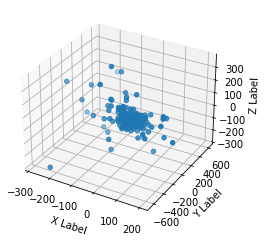

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_stars['x'], df_stars['y'], df_stars['z'])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

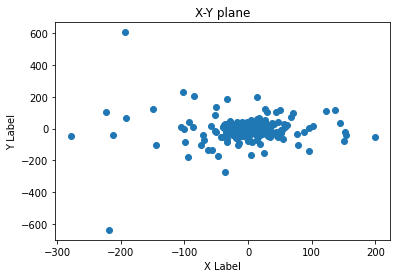

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111,)

ax.scatter(df_stars['x'], df_stars['y'])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')

plt.title("X-Y plane")
plt.show()

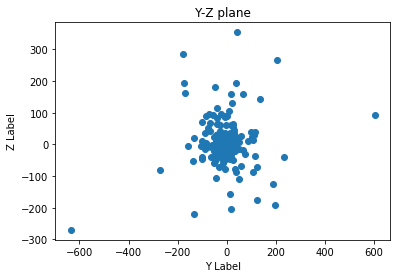

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111,)

ax.scatter(df_stars['y'], df_stars['z'])

ax.set_xlabel('Y Label')
ax.set_ylabel('Z Label')


plt.title("Y-Z plane")
plt.show()

So I have to first do a histogram of of masses. 
What would the binning be?
Should do a programm that creates bins with changable lentgh and fills them.

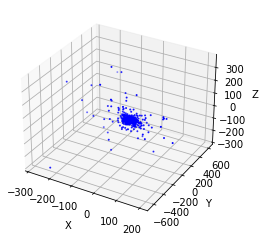

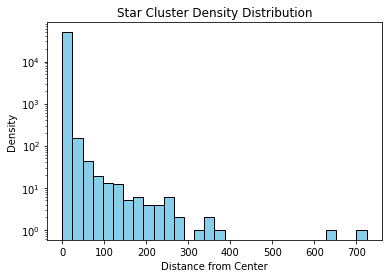

In [68]:
# Assuming 'star_df' is your DataFrame with columns 'x', 'y', 'z'
# Calculate the distance of each star from the center (middle) of the cluster
star_df = df_stars

#star_df['distance'] = np.sqrt(star_df['x']**2 + star_df['y']**2 + star_df['z']**2)

# Plot the 3D distribution of stars (optional but useful for visualization)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(star_df['x'], star_df['y'], star_df['z'], s=1, c='b', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# Create a histogram of the distances
plt.hist(star_df['distance'], bins=30, color='skyblue', edgecolor='black',log = True)
#plt.xlim(0, 4) 
plt.title('Star Cluster Density Distribution')
plt.xlabel('Distance from Center')
plt.ylabel('Density')
plt.show()

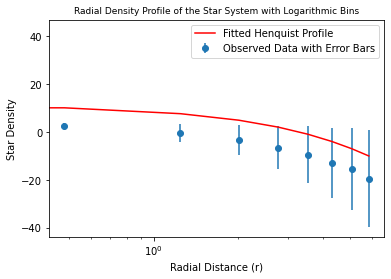

In [67]:
# define radial distances
radial_distances = df_stars["distance"]

# Define logarithmic bins
log_bins = np.logspace(np.log10(np.min(radial_distances)), np.log10(np.max(radial_distances)), 20)

# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=log_bins)

# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
star_density = hist / shell_volumes # This is the lambda

# Calculate Poisson errors
errors = np.sqrt(hist) / shell_volumes # This is the np.sqrt(lambda)

# Use curve_fit to find the optimal parameters with errors
params, covariance = curve_fit(hernquist_profile, bin_edges[:-1], star_density, sigma=errors, absolute_sigma=True)



# Plot the observed data and the fitted profile with error bars
plt.errorbar(np.log(bin_edges[:-1]), np.log(star_density), yerr=np.log(errors), fmt='o', label='Observed Data with Error Bars')
plt.plot(np.log(bin_edges[:-1]), np.log(fitted_profile), label='Fitted Henquist Profile', color='red')
plt.xscale('log')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Star Density')
plt.legend()
plt.title('Comparison with Hernquist Profile')
plt.title('Radial Density Profile of the Star System with Logarithmic Bins', fontsize = 9)
plt.show()

In [ ]:
a_fit

array([1.29013535e+04, 5.33686134e-02])

In [28]:
print(len(params))

array([[3.33099418e+03, 4.76897331e-06],
       [4.76897332e-06, 1.15921231e-07]])

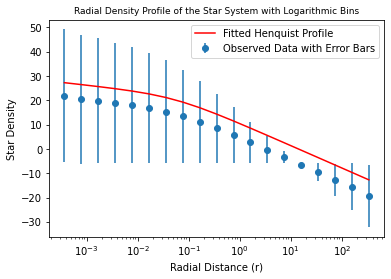

In [52]:
# define radial distances
radial_distances = df_stars["distance"]

# Define logarithmic bins
log_bins = np.logspace(np.log10(np.min(radial_distances)), np.log10(np.max(radial_distances)), 20)

# Count stars in each bin and get the bin edges
hist, bin_edges = np.histogram(radial_distances, bins=log_bins)

# Calculate volumes of each shell using the bin edges 
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
star_density = hist / shell_volumes

# Use curve_fit to find the optimal parameter for a (scale factor)
params, covariance = curve_fit(hernquist_profile_fixed_M, bin_edges[:-1], star_density, sigma=errors, absolute_sigma=True)

#extract the fitted scale factor a
a_fit = params

fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], a_fit)

e_pos = fitted_profile-star_density/np.sqrt(hist)
# Plot the observed data and the fitted profile with error bars
plt.errorbar(bin_edges[:-1], np.log(star_density), yerr=np.log(e_pos), fmt='o', label='Observed Data with Error Bars')
#plt.plot(bin_edges[:-1], np.log(star_density), marker='o')
plt.plot(bin_edges[:-1], np.log(fitted_profile), label='Fitted Henquist Profile', color='red')
#plt.axvline(x=np.log(a_fit), color='red', linestyle='--', label='scale radius a')
plt.xscale('log')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Star Density')
plt.legend()
plt.title('Comparison with Hernquist Profile')
plt.title('Radial Density Profile of the Star System with Logarithmic Bins', fontsize = 9)
plt.show()

In [53]:
pcov

array([[inf]])

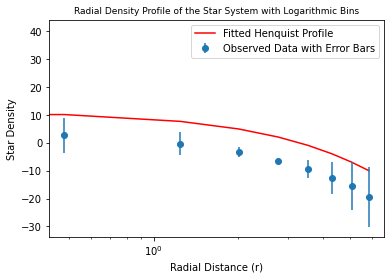

In [54]:
a_fit, pcov = curve_fit(hernquist_profile_fixed_M, bin_edges[:-1], star_density)
fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], a_fit)

#calculate error
e_pos = abs(fitted_profile-star_density)/np.sqrt(hist)


plt.plot(np.log(bin_edges[:-1]), np.log(fitted_profile), label='Fitted Henquist Profile', color='red')
plt.errorbar(np.log(bin_edges[:-1]), np.log(star_density), yerr=np.log(e_pos), fmt='o', label='Observed Data with Error Bars')
#plt.plot(bin_edges[:-1], np.log(star_density), marker='o')
plt.xscale('log')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Star Density')
plt.legend()
plt.title('Comparison with Hernquist Profile')
plt.title('Radial Density Profile of the Star System with Logarithmic Bins', fontsize = 9)
plt.show()

In [31]:
a_fit

array([0.82558247])

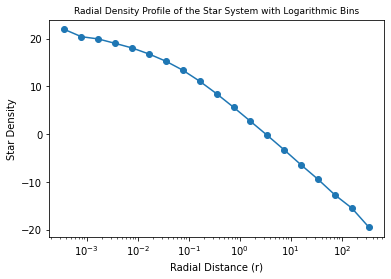

In [149]:
# define radial distances
radial_distances = df_stars["distance"]

# Define logarithmic bins
log_bins = np.logspace(np.log10(np.min(radial_distances)), np.log10(np.max(radial_distances)), 20)

# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=log_bins)

# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
star_density = hist / shell_volumes #rho_numerical

# Plot the radial density profile with logarithmic bins
plt.plot(bin_edges[:-1], np.log(star_density), marker='o')
plt.xscale('log')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Star Density')
plt.title('Radial Density Profile of the Star System with Logarithmic Bins', fontsize = 9)
plt.show()

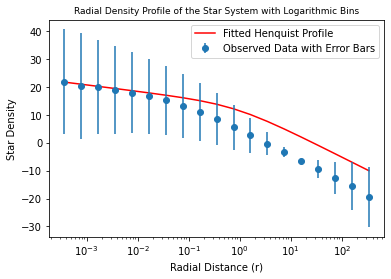

In [8]:
a_fit, pcov = curve_fit(hernquist_profile_fixed_M, bin_edges[:-1], star_density)
fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], a_fit)

#calculate error
e_pos = abs(fitted_profile-star_density)/np.sqrt(hist)


plt.plot(bin_edges[:-1], np.log(fitted_profile), label='Fitted Henquist Profile', color='red')
plt.errorbar(bin_edges[:-1], np.log(star_density), yerr=np.log(e_pos), fmt='o', label='Observed Data with Error Bars')
#plt.plot(bin_edges[:-1], np.log(star_density), marker='o')
plt.xscale('log')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Star Density')
plt.legend()
plt.title('Comparison with Hernquist Profile')
plt.title('Radial Density Profile of the Star System with Logarithmic Bins', fontsize = 9)
plt.show()

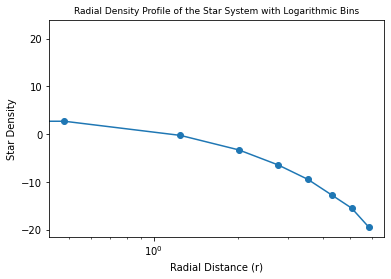

In [66]:
# define radial distances
radial_distances = df_stars["distance"]

# Define logarithmic bins
log_bins = np.logspace(np.log10(np.min(radial_distances)), np.log10(np.max(radial_distances)), 20)

# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=log_bins)

# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3) #

# Calculate star density in each shell for 
star_density = hist / shell_volumes #rho_numerical

# Plot the radial density profile with logarithmic bins
plt.plot(np.log(bin_edges[:-1]), np.log(star_density), marker='o')
plt.xscale('log')
plt.xlabel('Radial Distance (r)')
plt.ylabel('Star Density')
plt.title('Radial Density Profile of the Star System with Logarithmic Bins', fontsize = 9)
plt.show()

fixed mass profile a value:[0.005]


/scratch/tmp.42882350.atepper/ipykernel_11146/4042980114.py:9: RuntimeWarning:

divide by zero encountered in divide

/scratch/tmp.42882350.atepper/ipykernel_11146/1931522589.py:31: RuntimeWarning:

divide by zero encountered in log

/scratch/tmp.42882350.atepper/ipykernel_11146/1931522589.py:33: RuntimeWarning:

divide by zero encountered in log



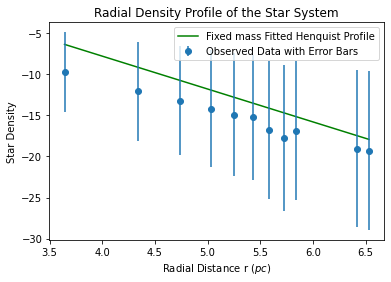

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# define radial distances
radial_distances = df_stars["distance"]

# Define radial bins
bins = np.linspace(0, np.max(radial_distances), 20)

# Count stars in each bin
hist, bin_edges = np.histogram(radial_distances, bins=bins)

# Calculate volumes of each shell
shell_volumes = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

# Calculate star density in each shell
star_density = hist / shell_volumes


a_fit, pcov = curve_fit(hernquist_profile_fixed_M, bin_edges[:-1], star_density,p0=0.005)
fixed_M_fitted_profile = hernquist_profile_fixed_M(bin_edges[:-1], a_fit)
print(f'fixed mass profile a value:{a_fit}')






# Plot the radial density profile
#plt.plot(np.log(bin_edges[:-1]), np.log(regular_fitted_profile), label='Fitted Henquist Profile', color='red')
plt.plot(np.log(bin_edges[:-1]), np.log(fixed_M_fitted_profile), label='Fixed mass Fitted Henquist Profile', color='green')
#plt.scatter(np.log(bins[:-1]), np.log(star_density), marker='o')
plt.errorbar(np.log(bin_edges[:-1]), np.log(star_density), yerr=np.log(sigma), fmt='o', label='Observed Data with Error Bars')
plt.xlabel('Radial Distance r ($pc$)')
plt.ylabel('Star Density')
plt.legend()
plt.title('Radial Density Profile of the Star System')
plt.show()

In [ ]:
result_df = df[df['your_column'] == desired_value]


In [177]:
example_star = df_stars[df_stars["distance"] == 724.689657812915  ] 

In [178]:
example_star

mass        x        y        z       vx       vy       vz  soft  \
33830  92.4259 -219.267 -635.776 -269.974  61.1198 -28.4596  32.0028   0.1   

            pot    distance  
33830  0.013022  724.689658

In [179]:
r_tot = 724.689657812915#pc
v = np.sqrt(total_mass/724.689657812915)

In [180]:
v

79.86366559905319

In [ ]:
# Example DataFrame with columns: 'StarID', 'X', 'Y', 'Z'
data = {'StarID': [1, 2, 3],
        'X': [1.0, 2.0, 3.0],
        'Y': [1.0, 1.5, 2.0],
        'Z': [5.0, 4.0, 2.0]}

star_cluster_df = pd.DataFrame(data)

# Calculate the Euclidean distance for each pair of particles (numpy)
distances_np = np.linalg.norm(star_cluster_df[['X', 'Y', 'Z']].values, axis=1)
print(distances_np)
# Calculate pairwise distances using Euclidean distance metric (scipy)
pairwise_distances = pdist(star_cluster_df[['X', 'Y', 'Z']].values, metric='euclidean')
print(pairwise_distances)
# Convert to a square matrix
distance_matrix = squareform(pairwise_distances)

# Exclude diagonal elements (distances to themselves)
non_diagonal_distances = distance_matrix[~np.eye(distance_matrix.shape[0], dtype=bool)]

# Calculate the mean distance for both approaches
mean_distance_np = distances_np[distances_np != 0].mean()
mean_distance_scipy = non_diagonal_distances.mean()

print(f"Mean Distance between particles (numpy): {mean_distance_np}")
print(f"Mean Distance between particles (scipy): {mean_distance_scipy}")

In [ ]:
#Parallelized version. Not sure if works, because 1000 particle really did not show any speed up against the regular on
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

def pairwise_distance(args):
    i, j, star_coordinates = args
    return euclidean_distance(star_coordinates.iloc[i], star_coordinates.iloc[j])

def mean_distance(star_coordinates):
    num_stars = len(star_coordinates)
    total_distance = 0.0

    # Using ThreadPoolExecutor for parallelization
    with ThreadPoolExecutor() as executor:
        # Create a list of argument tuples for pairwise_distance function
        args_list = [(i, j, star_coordinates) for i in range(num_stars) for j in range(i+1, num_stars)]
        
        # Map the pairwise_distance function to the list of arguments using multiple threads
        distances = list(executor.map(pairwise_distance, args_list))

        # Sum up the distances
        total_distance = sum(distances)

    # Calculate the mean distance
    mean_distance = total_distance / (num_stars * (num_stars - 1) / 2)
    return mean_distance

# Example coordinates of 10 stars in a DataFrame
# the half mass radius stars coordinates
star_cluster_df = f_df_stars[["x","y","z"]][:1000]

result = mean_distance(star_cluster_df)
print(f"Mean distance between stars: {result}")

In [35]:
def calculate_force(m_j,x1,y1,z1,x2,y2,z2,epsilon):
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    #G = 1
    force = ((m_j)/(r12**2+epsilon**2)**(1.5))*np.array([(x2-x1),(y2-y1),(z2-z1)])
    return force

In [38]:
stars = df_stars[:2]
i=0
j=1
calculate_force(stars['mass'][j],
                stars['x'][i], stars['y'][i], stars['z'][i],
                stars['x'][j], stars['y'][j], stars['z'][j], epsilon)

array([ -270.48838683, -1612.50867626,    77.70457927])

In [37]:
stars = df_stars[:2]
stars["mass"]

0    92.4259
1    92.4259
Name: mass, dtype: float64